<h1>Machine learning</h1>

In [109]:
#création jeux train et test
X_train, X_test, y_train, y_test = train_test_split(df[['sentence']], df['sentiment'])

In [110]:
"""CountVectorizer de Scikit-learn est utilisé pour transformer un corpus de mots en 
vecteurs/occurence des mots """
#Tf signifie term-frequency tandis que tfidf signifie inverse document-frequency
#IDF(word) = Log((Total number of documents)/(Number of documents containing the word))
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentence'])
feat_train = pipe.transform(X_train['sentence'])
feat_train.shape

(23209, 9456)

In [111]:
#minimum et maximum pour feat_train
feat_train.min(), feat_train.max()

(0.0, 1.0)

In [112]:
#transform sans fit sur le jeu test
feat_test = pipe.transform(X_test['sentence'])
feat_test.shape

(7737, 9456)

In [113]:
#définir les paramètres
#le paramètre max_depth est un seuil sur la profondeur maximale de l’arbre
"""L'indice de diversité de gini : probabilité pour chaque élément d'être choisi multipliée 
par la probabilité qu'il soit mal classé"""
"""L'entropie au lieu d'utiliser les probabilités simples applique le log2 des probabilités"""
param_grid = {'max_depth' : [40, 60], 
              'criterion' : ['gini', 'entropy']}
             
dtc = DecisionTreeClassifier(random_state=42)

dtc_grid = GridSearchCV(dtc, param_grid, cv=3)
 
#entrainer le modèle à partir de Grid Search
%time CV_dtc = dtc_grid.fit(feat_train, y_train)

print(dtc_grid.best_score_.round(5))
print(dtc_grid.best_params_)

final_model = dtc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 26.3 s
0.91223
{'criterion': 'entropy', 'max_depth': 60}


In [114]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3968
           1       1.00      0.99      0.99     19241

    accuracy                           0.99     23209
   macro avg       0.97      0.99      0.98     23209
weighted avg       0.99      0.99      0.99     23209



In [115]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1258
           1       0.95      0.95      0.95      6479

    accuracy                           0.92      7737
   macro avg       0.85      0.86      0.85      7737
weighted avg       0.92      0.92      0.92      7737



In [116]:
def MatriceConfusion(model):
    y_pred = model.predict(feat_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, pred_test)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

[[ 966  292]
 [ 338 6141]]


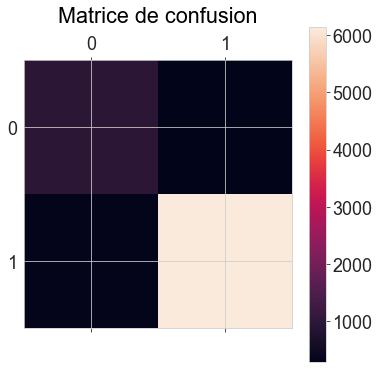

In [117]:
y_prediction = MatriceConfusion(CV_dtc)

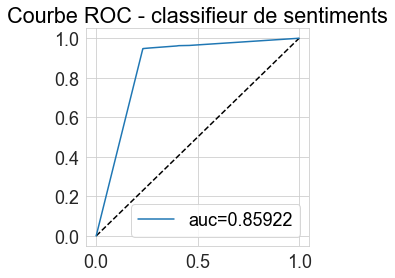

In [118]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [119]:
"""n_estimators = le nombre d'arbres dans la fôrét"""
"""Le Bootstrapping est un procédé qui permet d’augmenter artificiellement le nombre d’observation d’un 
échantillon de données sans pour autant modifier la distribution des variables présentes dans le jeu de 
données. Le principe est simple, on dispose d’un jeu de données contenant n observations, pour créer un 
échantillon de taille n on tire avec remise n observations parmi le jeu de données original"""
param_grid = {#'max_depth' : [40, 60],
             #'n_estimators' : [30, 50, 200],
              'bootstrap' : [True, False],
              'criterion' : ['gini', 'entropy']}

rfc = RandomForestClassifier(random_state=42)

rfc_grid = GridSearchCV(rfc, param_grid, cv = 3)

%time CV_rfc=rfc_grid.fit(feat_train, y_train)

print(rfc_grid.best_score_.round(5))
print(rfc_grid.best_params_)

final_model = rfc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 6min 3s
0.92908
{'bootstrap': False, 'criterion': 'entropy'}


In [120]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3968
           1       1.00      1.00      1.00     19241

    accuracy                           1.00     23209
   macro avg       1.00      1.00      1.00     23209
weighted avg       1.00      1.00      1.00     23209



In [121]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.95      0.64      0.76      1258
           1       0.93      0.99      0.96      6479

    accuracy                           0.94      7737
   macro avg       0.94      0.82      0.86      7737
weighted avg       0.94      0.94      0.93      7737



[[ 804  454]
 [  42 6437]]


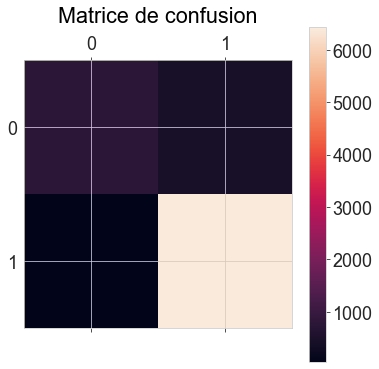

In [122]:
y_pred = MatriceConfusion(CV_rfc)

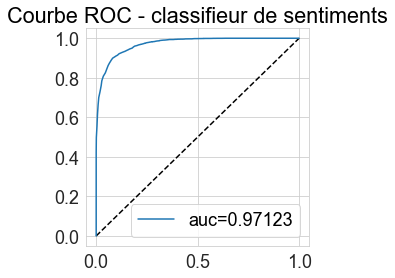

In [123]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [124]:
"""L1 : Lasso et L2 : Ridge, pénalité, c’est une modification qu’on apporte à la fonction de coût 
afin de maîtriser l’arbitrage entre biais vs variance"""
"""la fonction de coût est définie comme le carré de la différence entre la valeur prévue et la 
valeur réelle en fonction de l'intrant"""
param_grid = {'penalty' : ['l1', 'l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lr = LogisticRegression(random_state=42)

lr_grid = GridSearchCV(lr, param_grid, cv = 3)

%time CV_lr=lr_grid.fit(feat_train, y_train)

print(lr_grid.best_score_.round(5))
print(lr_grid.best_params_)

final_model = lr_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 6.79 s
0.95161
{'penalty': 'l1', 'solver': 'liblinear'}


In [125]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3968
           1       0.97      0.98      0.98     19241

    accuracy                           0.96     23209
   macro avg       0.94      0.92      0.93     23209
weighted avg       0.96      0.96      0.96     23209



In [126]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1258
           1       0.97      0.98      0.97      6479

    accuracy                           0.96      7737
   macro avg       0.93      0.91      0.92      7737
weighted avg       0.95      0.96      0.95      7737



[[1052  206]
 [ 139 6340]]


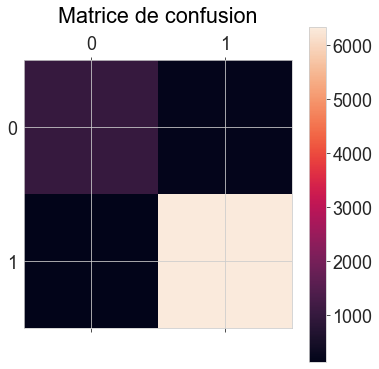

In [127]:
y_pred = MatriceConfusion(CV_lr)

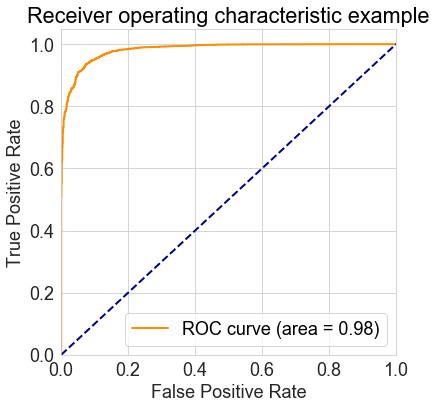

In [128]:
y_score = CV_lr.decision_function(feat_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [129]:
"""Le mot Bagging est une contraction de Bootstrap Aggregation : sélection de sous-ensembles aléatoires de
l'ensemble des données d'origine, puis agrégation des prédictions individuelles pour former une prédiction
finale""" 
naivebayes = nb.BernoulliNB()
modelB = BC(base_estimator = naivebayes, n_estimators = 1000, warm_start = True, bootstrap_features=True, max_samples=0.9)
modelB_fit = modelB.fit(feat_train, y_train)
modelB_fit.score(feat_test,y_test)
pred_train = modelB.predict(feat_train)
pred_test = modelB.predict(feat_test)

In [130]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.62      0.79      0.69      3968
           1       0.95      0.90      0.93     19241

    accuracy                           0.88     23209
   macro avg       0.79      0.84      0.81     23209
weighted avg       0.90      0.88      0.89     23209



In [131]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.56      0.70      0.63      1258
           1       0.94      0.89      0.92      6479

    accuracy                           0.86      7737
   macro avg       0.75      0.80      0.77      7737
weighted avg       0.88      0.86      0.87      7737



[[ 883  375]
 [ 684 5795]]


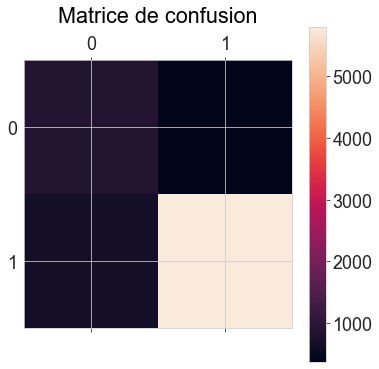

In [132]:
y_pred = MatriceConfusion(modelB)

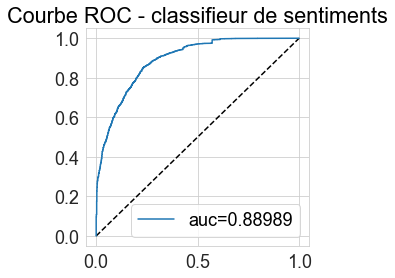

In [133]:
score = modelB_fit.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [134]:
param_grid = {#'C': [10, 50, 100,200],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']}

svm = svm.SVC(random_state=42)

clf_grid = GridSearchCV(svm, param_grid, cv=3)

svm = clf_grid.fit(feat_train, y_train)

print(clf_grid.best_score_.round(2))
print(clf_grid.best_params_)

final_model = clf_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

0.94
{'kernel': 'rbf'}


In [136]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3968
           1       0.97      0.98      0.98     19241

    accuracy                           0.96     23209
   macro avg       0.94      0.92      0.93     23209
weighted avg       0.96      0.96      0.96     23209



In [137]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1258
           1       0.97      0.98      0.97      6479

    accuracy                           0.96      7737
   macro avg       0.93      0.91      0.92      7737
weighted avg       0.95      0.96      0.95      7737



[[1052  206]
 [ 139 6340]]


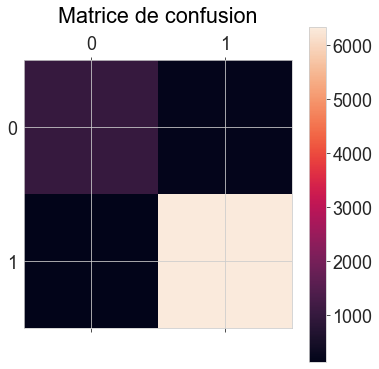

In [138]:
y_pred = MatriceConfusion(svm)

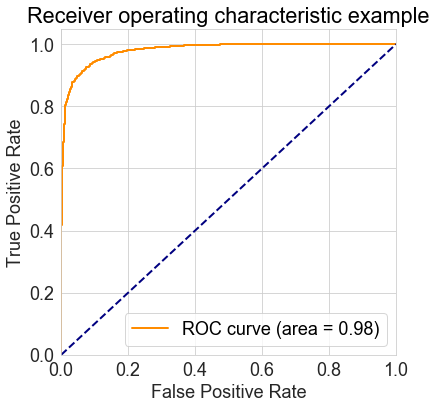

In [139]:
y_score = svm.decision_function(feat_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [140]:
param_grid = {
    #"learning_rate": [0.05,0.01, 0.1],
    #"max_depth":[20, 30, 50],
    #"criterion": ["friedman_mse", "mae", "mse"],
    'n_estimators' : [30, 50, 70]}

gbc=GradientBoostingClassifier(random_state=42)

gbc_grid = GridSearchCV(gbc, param_grid, cv = 3)

%time GBC = gbc_grid.fit(feat_train, y_train)
print (gbc_grid.best_score_.round(5))
print(gbc_grid.best_params_)

final_model = gbc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 1min 59s
0.88754
{'n_estimators': 70}


In [141]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.95      0.38      0.55      3968
           1       0.89      1.00      0.94     19241

    accuracy                           0.89     23209
   macro avg       0.92      0.69      0.74     23209
weighted avg       0.90      0.89      0.87     23209



In [142]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.93      0.37      0.53      1258
           1       0.89      0.99      0.94      6479

    accuracy                           0.89      7737
   macro avg       0.91      0.68      0.73      7737
weighted avg       0.90      0.89      0.87      7737



[[ 462  796]
 [  33 6446]]


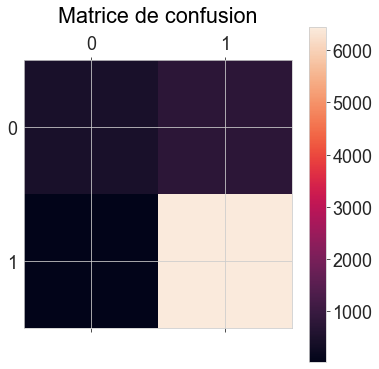

In [143]:
y_pred = MatriceConfusion(GBC)

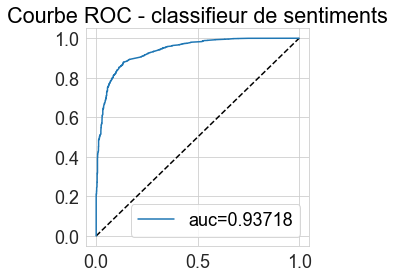

In [144]:
score = gbc_grid.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [145]:
#un n-gramme est “une sous-séquence de n éléments construite à partir d’une séquence donnée” 
#n-gramme permet de créer un modèle probabiliste pour anticiper le prochain élément d’une suite
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

[(None, None, 'tres'),
 (None, 'tres', 'bien'),
 ('tres', 'bien', 'établ'),
 ('bien', 'établ', 'a'),
 ('établ', 'a', 'bon'),
 ('a', 'bon', 'situat'),
 ('bon', 'situat', 'géograph')]

In [146]:
#Un 2-gram (or bi-gram) est une séquance de 2 mots : “please turn”, “turn your”
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentence'])
feat_train2 = pipe2.transform(X_train['sentence'])
feat_train2.shape

(23209, 149134)

In [147]:
#get_feature_names() - retourne une liste de feature names, classés par leurs indices
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

['ab',
 'ab climatis',
 'abandon',
 'abandon ancien',
 'abandon chambr',
 'abandon commun',
 'abandon couloir',
 'abandon dir',
 'abandon escali',
 'abandon idé']

In [148]:
feat_test2 = pipe2.transform(X_test['sentence'])

In [149]:
clf2 = LogisticRegression()
clf2.fit(feat_train2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [151]:
clf2.score(feat_test2, y_test)

0.9250355434923097

In [152]:
"""SVD est une technique de factorisation matricielle qui factorise une matrice M dans les trois matrices U,
Σ  et V. Très similaire à l'ACP, sauf que la factorisation pour SVD est effectuée sur la matrice de données, tandis que pour PCA, est une technique de factorisation matricielle qui factorise une matrice M dans les trois matrices U, Σ et V.Ceci est très similaire à l'ACP, sauf que la factorisation pour SVD est effectuée sur la matrice de données, 
pas sur la matrice de covariance."""
#n_components, dimensions qui doivent être inférieures aux colonnes
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['sentence'])
feat_train_svd = pipe_svd.transform(X_train['sentence'])
feat_train_svd.shape

(23209, 300)

In [153]:
clf_svd = RandomForestClassifier(n_estimators=50, max_depth=40, random_state=42)
clf_svd.fit(feat_train_svd, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [154]:
feat_test_svd = pipe_svd.transform(X_test['sentence'])
clf_svd.score(feat_test_svd, y_test)

0.9106888975054931

In [155]:
lr_svd = LogisticRegression()
lr_svd.fit(feat_train_svd, y_train)
lr_svd.score(feat_test_svd, y_test)

0.9396406876050148

In [156]:
pipe_svd_tfidf = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train['sentence'])
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train['sentence'])

clf_svd_tfidf = LogisticRegression()
clf_svd_tfidf.fit(feat_train_svd_tfidf, y_train)

feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test['sentence'])
clf_svd_tfidf.score(feat_test_svd_tfidf, y_test)

0.9324027400801345